# IMDB Sentiment Analysis

**By Neuromatch Academy**

__Content creators:__  Mahdi Anvari, Hossein Ghermezcheshme, Sujal Awasthi, Harshil Shah

__Production editors:__ Mahdi Anvari

In [ ]:
# Import needed libraries
import pandas as pd
import numpy as np
import re
import torch
import torchtext
torchtext.disable_torchtext_deprecation_warning()
from torch.utils.data import DataLoader, Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [ ]:
# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Loading dataset

In [ ]:
# Import the dataset from google drive
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/IMDBdataset.csv')

Mounted at /content/drive


In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
texts = df['review'].tolist()
labels = df['sentiment'].tolist()

label_map = {'positive': 1, 'negative': 0}
numeric_labels = [label_map[label] for label in labels]
numeric_labels = torch.tensor(numeric_labels)

**Preprocessing steps**

In [ ]:
# Text cleaning function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove digits
    return text

# Tokenization function
def tokenize(text):
    return word_tokenize(text)

# Stop words removal function
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

# Stemming function
def stem_tokens(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in tokens]

# Lemmatization function
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

def preprocess(text):
    text = clean_text(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_tokens(tokens)
    return ' '.join(tokens)

def preprocess_and_tokenize(text):
    text = clean_text(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_tokens(tokens)
    return tokens


In [ ]:
df['cleaned_review'] = df['review'].apply(preprocess)
df.head()

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


Lets make an example

In [ ]:
sample_text = "I loved this movie! It was amazing, the acting was great and the plot was very exciting."
print(sample_text)
print(preprocess(sample_text))
print(preprocess_and_tokenize(sample_text))

I loved this movie! It was amazing, the acting was great and the plot was very exciting.
loved movie amazing acting great plot exciting
['loved', 'movie', 'amazing', 'acting', 'great', 'plot', 'exciting']


In [ ]:
preprocessed_tokens = [preprocess_and_tokenize(text) for text in texts]

Building vocabulary

In [ ]:
# Build vocabulary from the tokenized texts
from collections import Counter
def yield_tokens(data_iter):
    for tokens in data_iter:
        yield tokens

vocab = build_vocab_from_iterator(yield_tokens(preprocessed_tokens), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [ ]:
words = Counter()
for s in preprocessed_tokens:
  for w in s:
    words[w] += 1

sorted_words = list(words.keys())
sorted_nums = list(words.values())
sorted_words.sort(key=lambda w: words[w], reverse=True)
sorted_nums.sort(reverse=True)
print(f"Number of different reviews in our dataset: {len(preprocessed_tokens)}")
print(f"Number of different tokens in our dataset: {len(sorted_words)}")
print("Top 100 tokens and their frequencies:")
print(sorted_words[:100])
print(sorted_nums[:100])

Number of different reviews in our dataset: 50000
Number of different tokens in our dataset: 203664
Top 100 tokens and their frequencies:
['movie', 'film', 'one', 'like', 'time', 'good', 'character', 'get', 'even', 'story', 'would', 'make', 'see', 'really', 'scene', 'much', 'well', 'people', 'great', 'bad', 'also', 'show', 'first', 'dont', 'way', 'thing', 'made', 'could', 'think', 'life', 'go', 'know', 'watch', 'love', 'many', 'seen', 'actor', 'two', 'plot', 'say', 'never', 'look', 'acting', 'end', 'little', 'best', 'year', 'ever', 'better', 'take', 'man', 'come', 'still', 'work', 'part', 'find', 'something', 'want', 'give', 'lot', 'back', 'director', 'im', 'real', 'guy', 'watching', 'doesnt', 'performance', 'didnt', 'play', 'woman', 'actually', 'though', 'funny', 'another', 'nothing', 'going', 'role', 'u', 'new', 'old', 'every', 'girl', 'cant', 'point', 'cast', 'world', 'fact', 'thats', 'quite', 'day', 'got', 'pretty', 'feel', 'minute', 'thought', 'seems', 'around', 'young', 'comedy']

In [ ]:
print(sum(sorted_nums[:100]))
print(sum(sorted_nums))
print(sum(sorted_nums[:100])/sum(sorted_nums))

1476813
5923292
0.24932301159557896


interesting!

In [ ]:
print(sorted_nums[sorted_words.index("deep")])
print(sorted_nums[sorted_words.index("learning")])

1345
327


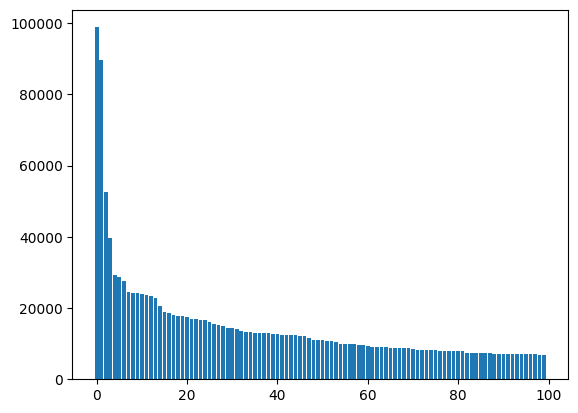

In [ ]:
import matplotlib.pyplot as plt
plt.bar(range(100), [words[w] for w in sorted_words[:100]])
plt.show()

Now, lets vectorize the samples

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=10000)

# Fit and transform the cleaned reviews
X = vectorizer.fit_transform(df['cleaned_review']).toarray()
Y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

In [ ]:
def check_nonzero_features(x):
  nonzero = x[x != 0]
  print("Number of nonzero features:" , len(nonzero))
  print((nonzero))
  # You can also get the index of nonzero features
  # print([index for index, value in enumerate(o != 0) if value])

In [ ]:
print(check_nonzero_features(X[0]))

Number of nonzero features: 123
[0.1028663  0.08938036 0.09996118 0.06715452 0.04167847 0.04649839
 0.04470474 0.05240101 0.09301927 0.09206266 0.05372835 0.07936075
 0.06829412 0.07380269 0.11454489 0.06091616 0.04895462 0.08506192
 0.05152562 0.09697236 0.0796384  0.08619639 0.07369995 0.04986384
 0.07027094 0.09727299 0.03905411 0.06374907 0.11700578 0.08619639
 0.10542281 0.03531657 0.05721346 0.05458655 0.08971955 0.04972946
 0.04126449 0.09583381 0.0439792  0.06383301 0.06279554 0.18426631
 0.06324049 0.05617086 0.04996127 0.07580308 0.06672387 0.04117884
 0.07046985 0.07819674 0.05725767 0.08429915 0.09258555 0.09847475
 0.05045067 0.08264021 0.09516898 0.19112771 0.08209823 0.0681925
 0.05215281 0.05299178 0.10092711 0.05636576 0.0471662  0.06920914
 0.07916594 0.1028663  0.09610939 0.04297925 0.06543121 0.06372498
 0.09742591 0.06015037 0.09324159 0.07170853 0.03463598 0.10310042
 0.02085851 0.05680063 0.44167246 0.08758273 0.05078579 0.04196571
 0.21401872 0.06467287 0.076864

Split the dataset

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [ ]:
del X
del Y

In [ ]:
import gc
gc.collect()

0

# Implementation

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(solver='saga')
LR_model.fit(X_train, Y_train)

LogisticRegression(solver='saga')

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
Y_pred_LR = LR_model.predict(X_test)
print(classification_report(Y_test, Y_pred_LR))
LR_acc = accuracy_score(Y_test , Y_pred_LR)
print(LR_acc)

              precision    recall  f1-score   support

           0       0.89      0.87      0.88     12582
           1       0.88      0.89      0.88     12418

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

0.88416


Multi Layer Perceptron

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

MLP_model = Sequential()
MLP_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.001)))
MLP_model.add(Dropout(0.5))
MLP_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
MLP_model.add(Dropout(0.2))
MLP_model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
MLP_model.add(Dense(1, activation='sigmoid'))

MLP_model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.004),
              metrics=['accuracy'])

history = MLP_model.fit(X_train, Y_train,
                    epochs=7,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/7
625/625 [==============================] - 29s 45ms/step - loss: 0.7933 - accuracy: 0.8288 - val_loss: 0.8236 - val_accuracy: 0.8560
Epoch 2/7
625/625 [==============================] - 20s 32ms/step - loss: 0.8184 - accuracy: 0.8521 - val_loss: 0.7974 - val_accuracy: 0.8574
Epoch 3/7
625/625 [==============================] - 20s 33ms/step - loss: 0.8242 - accuracy: 0.8590 - val_loss: 0.8167 - val_accuracy: 0.8406
Epoch 4/7
625/625 [==============================] - 20s 33ms/step - loss: 0.7997 - accuracy: 0.8578 - val_loss: 0.7926 - val_accuracy: 0.8548
Epoch 5/7
625/625 [==============================] - 23s 36ms/step - loss: 0.7907 - accuracy: 0.8571 - val_loss: 0.7439 - val_accuracy: 0.8666
Epoch 6/7
625/625 [==============================] - 23s 36ms/step - loss: 0.7742 - accuracy: 0.8561 - val_loss: 0.7358 - val_accuracy: 0.8618
Epoch 7/7
625/625 [==============================] - 21s 34ms/step - loss: 0.7676 - accuracy: 0.8589 - val_loss: 0.7231 - val_accuracy: 0.8624

In [ ]:
test_loss, test_accuracy = MLP_model.evaluate(X_test, Y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8655


Convolutional Neural Network

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Reshape X_train to fit the input shape of Conv1D
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

CNN_model = Sequential()
CNN_model.add(Conv1D(32, 5, activation='relu', input_shape=(10000, 1)))
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Conv1D(64, 5, activation='relu'))
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Flatten())
CNN_model.add(Dense(128, activation='relu'))
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(1, activation='sigmoid'))
CNN_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
CNN_model.fit(X_train_cnn, Y_train, epochs=2, batch_size=32, validation_split=0.2)

Epoch 1/2
625/625 [==============================] - 862s 1s/step - loss: 0.3794 - accuracy: 0.8278 - val_loss: 0.3154 - val_accuracy: 0.8612
Epoch 2/2
625/625 [==============================] - 874s 1s/step - loss: 0.2336 - accuracy: 0.9036 - val_loss: 0.3191 - val_accuracy: 0.8662


In [ ]:
# Evaluate the model
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

loss, accuracy = CNN_model.evaluate(X_test_cnn, Y_test, verbose=2)
print(f'Test Accuracy: {accuracy:.4f}')

782/782 - 193s - loss: 0.3113 - accuracy: 0.8712 - 193s/epoch - 246ms/step
Test Accuracy: 0.8712


Recurrent Neural Nrtwork

In [ ]:
# Reshape the data to have time steps and features per time step
sequence_length = 1
num_features = 10000

X_train_RNN = X_train.reshape((25000, sequence_length, num_features))
X_test_RNN = X_test.reshape((25000, sequence_length, num_features))

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam

RNN_model = Sequential()
RNN_model.add(SimpleRNN(400, input_shape=(1, 10000), return_sequences=False))
RNN_model.add(Dense(1, activation='sigmoid'))
RNN_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
RNN_model.fit(X_train_RNN, Y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
625/625 [==============================] - 62s 95ms/step - loss: 0.5504 - accuracy: 0.8286 - val_loss: 0.4107 - val_accuracy: 0.8682
Epoch 2/5
625/625 [==============================] - 63s 101ms/step - loss: 0.3204 - accuracy: 0.8954 - val_loss: 0.3058 - val_accuracy: 0.8816
Epoch 3/5
625/625 [==============================] - 58s 93ms/step - loss: 0.2325 - accuracy: 0.9209 - val_loss: 0.2796 - val_accuracy: 0.8838
Epoch 4/5
625/625 [==============================] - 64s 102ms/step - loss: 0.1876 - accuracy: 0.9369 - val_loss: 0.2735 - val_accuracy: 0.8836
Epoch 5/5
625/625 [==============================] - 61s 98ms/step - loss: 0.1572 - accuracy: 0.9485 - val_loss: 0.2788 - val_accuracy: 0.8830


In [ ]:
loss, accuracy = RNN_model.evaluate(X_test_RNN, Y_test, verbose=2)
print(f'Test Accuracy: {accuracy:.4f}')

782/782 - 11s - loss: 0.2711 - accuracy: 0.8895 - 11s/epoch - 14ms/step
Test Accuracy: 0.8895


Long Short-Term Memory

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

sequence_length = 1
num_features = 10000

X_train_LSTM = X_train.reshape((25000, sequence_length, num_features))
X_test_LSTM = X_test.reshape((25000, sequence_length, num_features))

LSTM_model = Sequential()
LSTM_model.add(LSTM(300, input_shape=(sequence_length, num_features), return_sequences=False))
LSTM_model.add(Dropout(0.5))
LSTM_model.add(Dense(1, activation='sigmoid'))
LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
LSTM_model.fit(X_train_LSTM, Y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
625/625 [==============================] - 231s 367ms/step - loss: 0.3642 - accuracy: 0.8579 - val_loss: 0.2761 - val_accuracy: 0.8822
Epoch 2/5
625/625 [==============================] - 237s 379ms/step - loss: 0.1823 - accuracy: 0.9309 - val_loss: 0.3051 - val_accuracy: 0.8742
Epoch 3/5
625/625 [==============================] - 241s 386ms/step - loss: 0.1278 - accuracy: 0.9549 - val_loss: 0.3658 - val_accuracy: 0.8690
Epoch 4/5
625/625 [==============================] - 236s 377ms/step - loss: 0.0921 - accuracy: 0.9702 - val_loss: 0.4489 - val_accuracy: 0.8578
Epoch 5/5
625/625 [==============================] - 232s 372ms/step - loss: 0.0646 - accuracy: 0.9801 - val_loss: 0.5330 - val_accuracy: 0.8536


In [ ]:
loss, accuracy = LSTM_model.evaluate(X_test_LSTM, Y_test, verbose=2)
print(f'Test Accuracy: {accuracy:.4f}')

782/782 - 28s - loss: 0.5262 - accuracy: 0.8606 - 28s/epoch - 36ms/step
Test Accuracy: 0.8606


BERT

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [ ]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
def analyze_sentiment(review):
    inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probabilities, dim=-1).item()
    labels = ["negative", "positive"]
    predicted_label = labels[predicted_class]
    return predicted_label

In [ ]:
sample_data = df.sample(5000)
y_pred = sample_data['review'].apply(analyze_sentiment)
y = sample_data['sentiment']
accuracy = (y_pred == y).mean()
print("Average Accuracy by BERT uncased model:", accuracy)


Average Accuracy by BERT uncased model: 0.895


Comparison

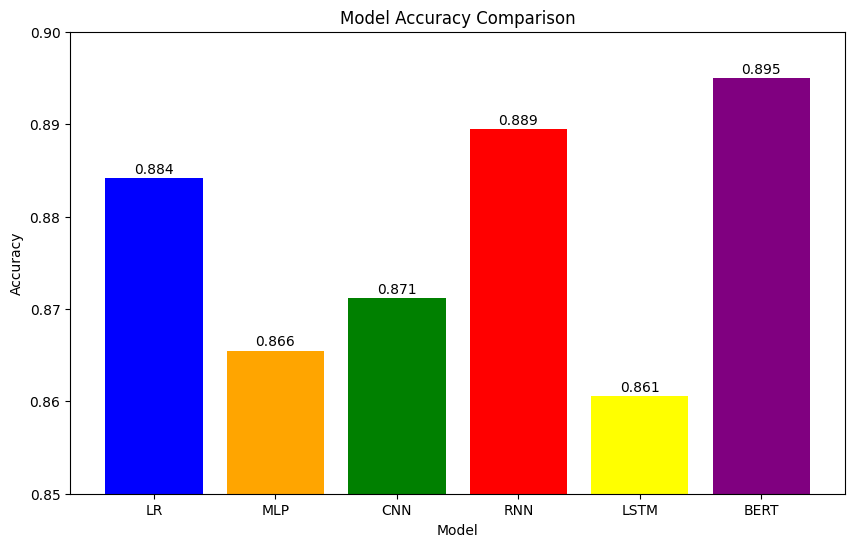

In [ ]:
import matplotlib.pyplot as plt
data = {
    'Model': ['LR' , 'MLP', 'CNN' , 'RNN' , 'LSTM' , 'BERT'],
    'Accuracy': [0.88416, 0.8655, 0.8712, 0.8895, 0.8606, 0.8950]
}

# Bar Plot
plt.figure(figsize=(10, 6))
plt.bar(data['Model'], data['Accuracy'], color=['blue' , 'orange' , 'green' , 'red' , 'yellow' , 'purple'])
for index, value in enumerate(data['Accuracy']):
    plt.text(index, value + 0.0005, f'{value:.3f}', ha='center')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0.85, 0.90)
plt.show()